# Final Project

## Framing

**Introduction**: describe your dataset, and why you're interested in it
The data is EDA/HR/Accelometer data from public speaking sessions during a class. I would like to be able to work with data from empatica, and I'm also interested in the science of public speaking.

**Research question(s)**: describe the overall research question of your project

**Hypotheses**:
    * Describe 2-3 hypotheses that you're planning to test with your dataset
    * Each hypoteses should be based on academic research (cite a paper) and/or background knowledge that you have about the dataset if you've collected it yourself (e.g., if you've conducted interviews)
    * Each hypotheses should be formulated as an affirmation (and not a question)
    * You can also describe alternative hypotheses, if you think that your results could go either way (but again, have a rationale as for why)
    
   1. The EDA and HR data pattern is correlated with quality of presentation. 
       +Less successful presenters and more successful presenters show a distinct pattern of EDA/HR. 
   2. The accelometer values can accurately predict how 'active' a speaker is perceived to be. 
   
   EDA is a proxy of stress. (Gjoreski, M., Luštrek, M., Gams, M., & Gjoreski, H. (2017). Monitoring stress with a wrist device using context. Journal of biomedical informatics, 73, 159-170.)
   HR is also a proxy, by some said to be more reliable for 'sudden' surprises.

**Results**:
    * how are you planning to test each hypothesis? What models are you thinking of using?
    * what are the best results you can hope for? Is that interesting / relevant for other researchers?
    * what are implications of your potential findings for practioners?
    1. I'll start with k-means clustering.
    2. I'll look at how accelometer patterns relate to enthusiasm/audience involvement/gesticulation, body language and facial expression composite score. 
    

**Threads**
    * Describe issues that might arise during the analyses above
    * Come up with backup plans in case you run into theses issues
    
    I'm not sure if accelometer measures are accurate, and also how to understand them. If they aren't accurate, I'll delve into the first hypothesis deeper. 
    I also found that EDA tends to have high inter-individual variability. I might follow Lemche et. al. (2005)'s method of calculating a relative EDA variable.

## Data Exploration

Describe your raw data below; provide definition / explanations for the measures you're using


EDA: electrodermal activation; proxy of arousal and stress. 
HR: heart rate; hoped to improve accuracy when added to EDA data.
Accelometer: Measures movement/ direction of movement of hand empatica is on. Hoped to predict 'activeness' of talk.

## Data Cleaning

Clean you data in this section, and make sure it's ready to be analyzed for next week!

#code in SpeakerEDA_clean (for hypothesis 1).

# Importing modules and reading in files

In [1]:
import numpy as np
print(np.__version__)
import scipy
print(scipy.__version__)

import pandas as pd
print(pd.__version__)
import sklearn
print(sklearn.__version__)
import pywt
print(pywt.__version__)

1.16.2
1.2.1
0.24.2
0.20.3
1.0.3


In [193]:
# using glob, find all the data files
import glob

files = glob.glob('./eda_acc/*.csv')
for i, file in enumerate(files):
    print(i, file)

0 ./eda_acc\output01.csv
1 ./eda_acc\output02.csv
2 ./eda_acc\output03.csv
3 ./eda_acc\output04.csv
4 ./eda_acc\output05.csv
5 ./eda_acc\output06.csv
6 ./eda_acc\output07.csv
7 ./eda_acc\output08.csv
8 ./eda_acc\output09.csv
9 ./eda_acc\output10.csv
10 ./eda_acc\output11.csv
11 ./eda_acc\output12.csv
12 ./eda_acc\output13.csv
13 ./eda_acc\output14.csv
14 ./eda_acc\output15.csv
15 ./eda_acc\output16.csv
16 ./eda_acc\output17.csv
17 ./eda_acc\output18.csv
18 ./eda_acc\output19.csv
19 ./eda_acc\output20.csv
20 ./eda_acc\output21.csv
21 ./eda_acc\output22.csv
22 ./eda_acc\output23.csv
23 ./eda_acc\output24.csv
24 ./eda_acc\output25.csv
25 ./eda_acc\output29.csv
26 ./eda_acc\output30.csv
27 ./eda_acc\output31.csv
28 ./eda_acc\output32.csv
29 ./eda_acc\output33.csv


In [3]:
orig_files = []
column_names = ['z-axis','y-axis','x-axis','battery','degrees_celcius', 'EDA_us']
#test = pd.read_csv(files[0],sep=',', header = None, skiprows = 8, names = column_names, engine = 'python')
for filename in files:
    orig_files.append(pd.read_csv(filename,sep=',', header = None, skiprows = 8, names = column_names, engine = 'python'))

In [430]:
# check for length of recording - sometimes, recordings go on for much longer after the presentation ended. 
for i, f in enumerate(orig_files):
    print(i, len(f.index))

0 30175
1 25071
2 29807
3 33615
4 31167
5 30127
6 26351
7 26399
8 75071
9 33439
10 73567
11 29455
12 30095
13 72015
14 23243
15 30223
16 30223
17 30223
18 28143
19 29279
20 29983
21 30031
22 30367
23 19071
24 29663
25 30303
26 30303
27 46907
28 45983
29 45983


In [127]:
# function: filter out data after 65mins for participant at indices 8, 10 and 13, whose recording went on after the presentation ended.

to_chop_indices = [8,10,13]

def cut_data(listdf, indices):
    for i in indices:
        df = listdf[i]
        listdf[i] = df[:31200]
    return listdf

trimmed_data = cut_data(orig_files,to_chop_indices)

for i, f in enumerate(trimmed_data):
    print(i, len(f.index))

0 30175
1 25071
2 29807
3 33615
4 31167
5 30127
6 26351
7 26399
8 31200
9 33439
10 31200
11 29455
12 30095
13 31200
14 23243
15 30223
16 30223
17 30223
18 28143
19 29279
20 29983
21 30031
22 30367
23 19071
24 29663
25 30303
26 30303
27 46907
28 45983
29 45983


# Heartrate

In [217]:
# create a list of dataframes; each holds one column, HR. downsampled to 1 datapoint per 5 seconds.

files = glob.glob('./**/HR.csv', recursive = True)
#print(files, len(files))    

HR = []
for i, file in enumerate(files):
    df = pd.read_csv(file,sep=',', header = None, skiprows = 2, names = ['HR'], engine = 'python')
    if i in to_chop_indices: 
        df = df[0:3900]
    df_downsample = df.rolling(5).mean()[::5]

    HR.append(df_downsample)



# Movement

In [21]:
# create a list of dataframes: each holds one column, movement
# Movement data is calculated using a moving average, with 1 datapoint per 5 seconds to later match with label data.
# The calculation of moving average follows the documentation on the Empatica website
# https://support.empatica.com/hc/en-us/articles/202028739-How-is-the-acceleration-data-formatted-in-E4-connect-

movement = []
for k, file in enumerate(trimmed_data):
    sum_movement = 0
    df = file.iloc[:, 0:3]
    df['movement'] = np.nan
    print('length of', k,'th file:', len(df.index))
    

    for i in range(len(df.index)):

        # sample to 1 point per 5 seconds (current sampling rate at 8 Hz)
        if i % 40 != 0:
            sum_movement += max(np.absolute(df.iloc[i,0]-df.iloc[i-1,0]), np.absolute(df.iloc[i,1]-df.iloc[i-1,1]), 
                                 np.absolute(df.iloc[i,2]-df.iloc[i-1,2]))
        elif i == 0:
            df.iloc[i,3] = 0

        else:
            # if i is a non-zero multiple of 40 
            df.iloc[i,3] = df.iloc[i-40,3] * 0.9 + sum_movement * 0.1
            print(df.iloc[i,3])
            sum_movement = 0

    movement.append(df.movement) 
movement[0]

C:\Users\gses\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


length of 0 th file: 30175


C:\Users\gses\Anaconda3\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\gses\Anaconda3\lib\site-packages\ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


0.5203125000000001
1.2854687500000002
1.767859375
2.3973234375
2.69665359375
3.5848007343750004
3.8950706609375008
3.9758760948437506
4.143913485359375
3.9826471368234375
3.960944923141094
4.025787930826985
3.829459137744286
3.9387007239698577
3.777643151572872
4.242066336415585
4.770984702774026
4.806386232496624
4.908560109246961
4.848954098322266
4.789058688490039
4.780465319641036
4.838356287676932
5.135770658909239
5.234693593018315
5.528411733716484
5.2365080603448355
4.744107254310352
4.300946528879317
3.897414375991385
3.5514229383922467
4.907218144553022
4.96962133009772
5.061721697087948
5.1086745273791525
4.964994574641238
4.999745117177114
4.862270605459402
5.569793544913463
6.026876690422117
6.039814021379906
6.054582619241915
6.235061857317724
5.645930671585952
5.128212604427357
4.648203843984621
4.241195959586159
4.029576363627544
3.6891187272647894
3.4045818545383106
3.4781861690844798
3.955367552176032
4.0270182969584285
3.691503967262586
3.3598535705363277
3.055118213

8.781724832185219
8.019177348966698
7.439134614070029
6.9577211526630265
7.421324037396724
8.357316633657051
7.895022470291346
7.560207723262212
7.722936950935991
8.356893255842392
7.711828930258153
7.228146037232337
8.820956433509103
8.335735790158193
9.572474711142373
9.443352240028137
8.695892016025324
7.9200528144227915
7.212422532980512
6.753680279682461
6.187687251714215
6.643918526542794
6.610776673888514
6.024699006499663
5.509729105849697
5.405631195264728
6.205693075738255
6.400748768164429
6.879423891347987
6.378981502213188
5.8676458519918695
5.499631266792683
5.034043140113415
4.657201326102074
4.322731193491866
4.0045205741426795
3.6884435167284115
4.200849165055571
4.044826748550014
3.951281573695012
3.728028416325511
3.5396005746929604
3.4247030172236648
3.6056702155012985
4.3904156939511685
4.220124124556052
3.8871742121004464
3.609394290890402
3.421892361801362
3.209390625621226
3.0353265630591033
2.898981406753193
2.7903332660778735
2.576924939470086
2.39110744552307

1.3627642379716969
1.3171128141745272
1.3385265327570746
1.3921738794813672
1.4560814915332305
1.4354733423799075
1.4106760081419167
1.5821084073277252
1.5348350665949526
1.5501015599354573
1.5638414039419115
1.4762072635477206
1.3817115371929487
1.3341653834736538
1.3194988451262883
1.2875489606136596
1.3103565645522937
1.3340084080970644
1.349045067287358
1.3313280605586222
1.3185077545027601
1.3022819790524842
1.3595537811472358
1.4345359030325122
1.358269812729261
1.2740053314563349
1.1981672983107015
1.1517880684796313
1.1959842616316683
1.2779483354685015
1.4782785019216513
2.0242006517294864
1.8936555865565377
1.793352527900884
1.6812047751107955
1.609959297599716
1.5458383678397445
1.45062953105577
1.352441577950193
1.2796974201551738
1.1970401781396567
1.119523660325691
1.059133794293122
1.0016579148638098
0.9280546233774289
0.8836866610396861
0.8703179949357176
0.8270361954421458
0.7740200758979312
0.7419305683081381
0.7333625114773243
0.9600262603295919
1.0421486342966328
1.

1.3025627509684532
1.262931475871608
1.5085133282844472
1.4935994954560026
1.4645520459104024
1.3899718413193622
1.3587871571874262
1.2713459414686834
1.2379613473218152
1.2219777125896338
1.1732174413306706
1.2012081971976036
1.1654623774778434
1.169228639730059
1.2382432757570534
1.595668948181348
2.4142270533632133
2.700929348026892
3.1214614132242033
3.4311902719017833
4.127133744711605
3.8034828702404444
3.8246970832164005
3.9000398748947607
4.097535887405285
4.6534072986647566
5.661504068798282
5.648478661918453
5.7945682957266085
6.158861466153947
5.555475319538553
6.078052787584698
6.046810008826228
5.442129007943605
4.904166107149244
4.41374949643432
3.9848745467908877
3.5895120921117987
3.239935882900619
2.919067294610557
2.6568480651495014
2.394288258634551
2.1579844327710958
1.9421859894939861
2.2229673905445875
length of 2 th file: 29807
0.028125
0.058125
0.08043750000000001
0.10676875000000001
0.13359187500000003
0.14523268750000004
0.16977191875000003
0.18248222687500004

1.461827089514856
1.3718943805633703
1.3143924425070332
1.23607819825633
1.2015328784306971
1.1360670905876273
1.0974603815288646
1.0361518433759782
1.0028491590383806
0.9525642431345426
0.9057453188210883
1.1136082869389794
1.6225599582450816
1.5978039624205733
1.5192735661785162
1.4282837095606646
1.618267838604598
1.7345660547441384
1.8454844492697247
2.0906235043427523
2.134686153908477
1.9712175385176294
1.9256582846658665
2.32371745619928
2.431970710579352
2.262211139521417
2.164115025569275
2.036766023012347
1.8784019207111127
1.7343117286400014
1.5968180557760012
1.480886250198401
1.4234226251785609
1.3420178626607049
1.2703160763946344
1.276096968755171
1.193799771879654
1.1134822946916887
1.07869656522252
1.167701908700268
1.1212442178302413
1.068494796047217
1.0210203164424954
0.9439182847982459
0.9182764563184214
0.8639488106865792
0.8634914296179214
1.3083922866561293
1.3963030579905165
1.3082352521914649
1.2149117269723184
1.1309205542750866
1.0553284988475782
0.988858148

6.267650037446982
5.684635033702285
5.156796530332056
4.661429377298851
4.212473939568966
3.9912265456120695
3.7561663910508627
3.4102372519457766
3.812963526751199
3.8441671740760794
3.5019379566684714
3.1876816610016245
2.901725994901462
2.647490895411316
2.4155543058701845
2.216186375283166
2.268005237754849
2.1193297139793645
1.9605217425814283
1.8113445683232856
1.7348976114909571
1.7176578503418614
2.2693295653076753
2.764271608776908
2.5487819478992173
2.798591253109296
3.267169627798366
4.313890165018529
4.085626148516676
4.770813533665008
5.7327946802985075
5.2251402122686565
4.733876191041791
4.382363571937612
4.014439714743851
3.661433243269466
3.7312274189425194
4.572167177048268
4.177450459343441
3.786267913409097
3.456078622068187
3.1542207598613685
2.8778611838752317
2.6525750654877087
3.2013800589389376
3.684367053045044
3.60186784774054
4.069806062966486
5.219075456669838
6.050292911002855
5.97182611990257
5.610581007912313
5.7432729071210815
5.264258116408974
4.769082

1.571751271774551
1.5052011445970959
1.4515560301373864
1.5095254271236478
1.478885384411283
1.4013093459701547
1.3471159113731392
1.3092793202358255
1.275226388212243
1.2445787493910188
1.1607458744519168
1.0790462870067252
1.0508291583060527
1.5801212424754474
1.7830466182279028
1.6391169564051127
1.5252052607646014
1.4320597346881412
1.3747912612193272
1.2919996350973946
1.211237171587655
1.6885509544288895
1.5759458589860005
1.5089762730874003
1.3893286457786604
1.4550832812007943
1.345512453080715
1.2578362077726435
1.3508025869953793
1.3157223282958415
1.2294625954662575
1.3424538359196316
1.3628959523276687
1.296918857094902
1.2422269713854117
1.2836292742468705
1.3974538468221835
1.5155209621399652
2.1264688659259687
2.034134479333372
2.019783531400035
2.7584301782600313
2.634149660434028
2.5004221943906257
2.3097549749515633
2.2584669774564072
2.2669952797107666
2.30592075173969
2.1347036765657212
1.980608308909149
1.8684849780182342
1.7472614802164108
1.6131603321947696
1.495

5.47091434881903
5.086322913937127
4.782378122543415
4.5369528102890735
4.223882529260166
4.46086927633415
4.066344848700735
4.070647863830662
3.676083077447596
3.3537872697028366
3.060596042732553
2.8576614384592975
2.760957794613368
2.6145495151520315
2.9359070636368285
3.353253857273146
3.3663659715458314
3.071916874391248
2.8131626869521233
2.574033918256911
2.35569302643122
2.210748723788098
2.045923851409288
1.8866439662683594
1.7104795696415234
1.542556612677371
1.469550951409634
1.4116583562686709
1.3376800206418038
1.3335995185776235
1.275239566719861
1.249278110047875
1.2306002990430873
1.2262902691387785
1.2661612422249007
1.1942326180024105
1.1451218562021694
1.1149846705819526
1.0800487035237574
1.0814188331713817
1.0748394498542435
1.0329805048688192
0.9812449543819373
0.9596829589437436
1.004339663049369
1.6601556967444324
1.6316401270699892
1.5731636143629903
1.5595972529266915
1.6161375276340224
1.52639877487062
1.4596963973835582
1.7027892576452024
1.677822831880682
1

3.201423922895507
2.989094030605956
2.7323721275453603
2.482572414790824
2.2530651733117417
2.0652586559805677
1.902482790382511
1.7372345113442598
1.5728860602098338
1.5655974541888504
1.4465377087699656
1.344071437892969
1.242476794103672
1.338541614693305
1.3234374532239743
1.2160937079015768
1.1304218371114192
1.0580046534002772
0.9865791880602495
0.9269837692542245
0.910847892328802
0.8557006030959218
0.8201305427863297
0.7756174885076967
0.7371182396569271
0.7352814156912345
0.708628274122111
0.6815154467098999
0.6961764020389101
0.7999962618350192
0.7606216356515173
0.7220594720863656
0.709228524877729
0.6976806723899561
0.6763501051509605
0.6899650946358645
0.6553435851722781
0.6538717266550503
0.6291095539895454
0.6193235985905908
0.6355162387315317
0.6079021148583785
0.9971119033725406
0.9255257130352865
0.8657856417317579
0.8042070775585821
0.7597238698027239
1.1868764828224516
1.1463138345402064
1.2441824510861856
1.2103892059775672
1.1034127853798106
1.0180715068418296
0.9

1.3801169833299969
1.3077302849969972
1.2253947564972973
1.1356677808475675
1.0549135027628107
0.9947346524865296
0.9249486872378766
0.8621413185140889
0.8181146866626801
0.7706782179964121
0.7326728961967709
0.7219056065770938
0.6934650459193844
0.6850560413274459
0.6493629371947014
0.6328641434752313
0.6008277291277082
0.5782449562149374
0.5438579605934437
0.5191596645340993
0.49536869808068945
0.47083182827262055
0.4393736454453585
0.4391862809008227
0.4562051528107405
0.5152721375296665
1.8465574237766997
3.1337766813990298
4.018836513259127
4.445077861933214
4.711507575739893
4.760669318165904
5.617414886349314
6.066610897714383
6.355262307942945
6.25723607714865
6.761199969433785
7.133517472490407
6.776415725241367
6.2112741527172295
5.705771737445506
5.428944563700956
4.964175107330861
4.583382596597774
4.278169336937997
3.9347274032441972
3.9631296629197776
3.8652541966278
3.5537287769650203
3.2983558992685182
3.0357078093416665
2.7774495284075
2.5653295755667496
2.360359118010

1.763191162049502
1.6899970458445517
1.5991223412600966
1.493897607134087
1.4038828464206783
1.3072445617786104
1.2546451056007493
1.2057430950406745
1.152356285536607
1.2558706569829463
1.2584085912846517
1.1981927321561865
1.1486859589405678
1.085379863046511
1.02684187674186
1.0038451890676738
0.9956481701609065
1.0304583531448157
1.0008500178303341
0.9742025160473008
0.9345947644425707
0.9130102879983137
0.9310842591984824
2.034850833278634
2.642303249950771
3.359322924955694
3.592140632460125
5.326676569214112
5.561196412292701
5.662889271063431
6.513787843957088
5.995221559561379
6.172261903605241
5.661285713244717
5.1529696419202455
4.690797677728221
4.276405409955399
3.9018898689598593
3.5648258820638734
3.269280793857486
2.9923527144717372
2.7509299430245635
3.1398994487221072
4.075909503849896
5.182381053464907
5.101642948118416
5.444603653306575
5.334518287975918
5.437003959178326
5.027678563260494
5.053035706934445
5.596169636241001
6.028740172616901
7.682116155355212
8.326

5.943693823723775
5.464949441351397
4.979391997216257
4.693952797494632
4.501120017745168
4.208820515970652
3.892625964373587
3.6283633679362284
3.4045895311426055
3.150068078028345
2.911623770225511
3.95014889320296
3.727009003882664
3.496495603494398
3.2390335431449584
2.990130188830463
2.753617169947417
2.542317952952675
2.395898657657408
2.342246291891667
2.5048966627025004
2.7731569964322507
2.603653796789026
2.4198509171101232
2.635678325399111
2.7142979928592004
2.5584931935732804
2.5432688742159524
2.487379486794357
2.5886415381149215
2.6563398843034296
2.4719558958730867
2.3216353062857777
2.1832217756572
2.4273995980914798
2.5924721382823317
2.4894749244540986
2.471777432008689
2.33397468880782
2.2224522199270385
2.067394497934335
3.3887800481409016
4.213964543326812
4.100380588994131
4.065342530094718
4.808808277085246
4.634177449376722
5.7285722044390495
6.283839983995144
6.82420598559563
6.7183478870360664
6.760575598332459
6.162643038499214
5.601066234649292
6.19095961118

1.0323023605085473
1.1150096244576926
1.1816336620119234
1.1212827958107312
1.2216545162296581
1.2479265646066924
1.3137589081460233
1.435508017331421
1.399769715598279
1.3957302440384511
1.471782219634606
1.5339789976711455
1.516518597904031
1.474241738113628
1.462755064302265
1.5321045578720385
1.4507691020848346
1.322879691876351
1.346841722688716
1.3715325504198443
1.2921917953778599
1.291097615840074
1.2432378542560667
1.18141406883046
1.716397661947414
1.9119453957526726
2.3129383561774053
2.114457020559665
1.9405113185036986
1.9589601866533286
1.9130641679879958
1.8139452511891965
1.849738226070277
1.8053894034632494
1.6764129631169244
1.613459166805232
1.5161757501247088
1.439558175112238
1.3706023576010142
1.6179171218409127
2.7905004096568216
3.8895753686911396
4.230305331822025
4.955712298639822
5.69295356877584
5.611158211898256
5.64379239070843
6.007538151637588
6.14740933647383
6.195168402826447
5.7834640625438025
5.486367656289422
5.31116839066048
5.214426551594433
4.991

2.3041637488156725
2.1159348739341053
1.930903886540695
1.7925009978866255
1.6382508980979629
1.4963008082881668
1.3685457274593502
1.2535661547134154
1.1453970392420738
1.0527323353178666
0.9677716017860799
0.895994441607472
0.8438949974467248
0.7813804977020523
0.746992447931847
0.6957307031386624
0.6480326328247962
0.5926043695423165
0.5645939325880849
0.5300095393292764
0.5004460853963488
0.48477647685671393
0.45817382917104255
0.4389189462539383
0.4200270516285445
0.40614934646569006
0.39365941181912106
0.38554347063720895
0.37511412357348806
0.3704152112161393
0.3880611900945254
0.3898800710850729
0.3821420639765656
0.39080285757890904
0.38766007182101814
0.3848315646389163
0.38697340817502474
0.8451510673575222
length of 8 th file: 31200
0.028125
0.059687500000000004
0.08809375
0.105846875
0.12963718750000003
0.16042346875000002
0.185006121875
0.19931800968750002
0.21219870871875002
0.23629133784687503
0.24859970406218754
0.25811473365596876
0.2635532602903719
0.2700104342613347

9.820748775004226
9.504298897503805
10.614806507753425
11.292388356978083
12.089712021280274
12.068240819152248
13.369229237237024
12.869806313513322
12.40157568216199
12.398918113945792
12.396526302551214
12.916248672296094
13.627748805066485
14.452473924559836
13.425976532103853
12.275566378893467
11.15738474100412
10.908833766903708
11.428887890213337
12.318811601192005
12.907242941072804
13.969643646965524
14.652366782268972
14.807442604042075
15.779823343637867
15.20496600927408
15.198531908346673
15.634928717512008
16.249560845760808
16.023042261184727
16.192613035066255
16.33741423155963
16.70523530840367
16.345649277563304
15.931396849806974
15.596069664826278
14.916150198343649
13.816722678509285
12.872550410658356
13.02435786959252
14.384422082633268
13.227229874369941
12.865444386932948
13.408587448239654
13.642728703415688
14.04564333307412
14.075453999766708
13.794471099790037
12.788461489811034
12.165865340829932
12.008653806746938
12.781225926072246
13.507790833465023
14

0.0037232242098406945
0.0033509017888566253
0.003015811609970963
0.0027142304489738665
0.00244280740407648
0.0021985266636688323
0.001978673997301949
0.0017808065975717542
0.0016027259378145788
0.001442453344033121
0.001298208009629809
0.001168387208666828
0.0010515484878001454
0.0009463936390201309
0.0008517542751181178
0.000766578847606306
0.16162742096284569
2.5814021788665613
3.7560744609799057
3.841404514881915
4.3010140633937235
6.044350157054351
6.616477641348917
6.8157673772140255
6.443565639492623
6.4288965755433605
6.545381917989025
5.964281226190122
5.38660310357111
5.710442793213999
5.208148513892599
4.696708662503339
4.252037796253006
4.6049590166277055
4.431963114964935
4.002829303468442
3.6353588731215973
3.6577604858094377
4.024796937228494
3.816067243505645
3.4813355191550803
3.9082019672395725
4.554881770515616
5.050956093464054
4.814610484117648
5.198774435705884
5.246084492135296
5.224601042921766
5.62089093862959
6.082239344766632
5.545890410289969
5.05223886926097

2.213653276374091
2.168850448736682
2.0050904038630137
1.9436438634767126
1.8789669771290414
1.9160702794161373
2.0432132514745236
1.9420169263270712
2.0915652336943644
2.0042837103249282
1.8772928392924355
1.902063555363192
1.9352946998268727
1.8089527298441854
1.706182456859767
1.6308767111737903
2.0381015400564113
1.9124163860507701
1.772737247445693
1.6610885227011238
1.5621671704310114
1.4590754533879104
1.3694179080491193
1.3371636172442074
1.2581347555197866
1.179196279967808
1.0909641519710274
1.0146802367739247
0.9553997130965323
0.9254847417868791
0.9751237676081912
0.9822988908473721
0.980944001762635
0.9359746015863715
0.9392521414277344
0.887514427284961
0.8300129845564649
0.8048241861008184
0.7915292674907365
0.7467513407416629
0.7923887066674967
0.8053373360007471
0.7341786024006725
0.6795107421606053
0.8131221679445447
1.6349349511500904
1.5745664560350812
1.457734810431573
1.3932113293884159
1.7538901964495743
1.6488136768046169
1.5386198091241552
1.9331953282117396
1.

1.8475162461678556
1.70346462155107
1.5784181593959632
1.4596763434563669
1.4589287091107301
1.8020158381996572
1.7533942543796914
2.006434828941722
2.5644513460475498
2.388586211442795
2.215727590298515
2.1430748312686636
1.9873273481417975
2.396894613327618
2.4762651519948564
2.304378636795371
2.131630773115834
1.9562776958042505
1.7973099262238255
1.653298933601443
1.5260290402412986
1.4054461362171686
1.980561522595452
3.344545370335907
4.194310833302316
4.637379749972085
4.451991774974877
4.238662597477389
4.58862633772965
4.786193703956685
5.088614333561017
5.350252900204915
5.854237610184423
6.762683849165981
8.001715464249383
8.275093917824446
8.485604526042001
9.398294073437802
8.982364666094021
8.908828199484619
9.605725379536157
9.495702841582542
9.234872557424287
9.460515301681859
9.228123771513673
8.722321394362305
9.313759254926076
8.867513329433468
8.06282199649012
7.347709796841109
6.868148817156998
6.309433935441298
5.743190541897168
5.219771487707451
4.732594338936706

1.0298177909770658
0.9964860118793593
1.1013674106914233
1.715370669622281
2.077093602660053
2.519164242394048
2.3908578181546436
2.6225420363391794
2.4464378327052616
2.4680240494347356
3.5509516444912617
3.7687964800421354
4.611046832037923
4.400112148834131
4.465670933950718
4.256923840555646
3.9287314565000817
3.6093583108500735
3.322422479765066
3.0460802317885594
2.7854722086097037
2.5465249877487333
2.34167248897386
2.607165240076474
2.4362487160688264
2.3254238444619437
2.8364514600157493
3.236786314014175
3.837057682612757
3.5818019143514817
3.2878817229163335
3.0123535506247
2.7723981955622303
2.550128376006007
2.504565538405407
3.2351789845648664
3.76002108610838
3.448518977497542
3.1445670797477874
3.2134803717730085
2.9565823345957076
2.690694101136137
2.4842146910225233
2.257993221920271
2.0573938997282437
1.8723545097554193
1.7249190587798775
1.5966271529018898
1.4711644376117008
1.3617479938505308
1.520883194465478
2.51338487501893
2.497016387517037
2.579034748765334
2.

3.8667177901155467
4.164421011103992
4.1167289099935935
4.0331810189942345
3.9579879170948113
4.12000162538533
3.7845639628467977
3.704545066562118
3.6434655599059065
3.6244315039153157
3.536988353523784
3.9786020181714057
3.7041793163542653
3.407198884718839
3.427416496246955
3.7456123466222597
3.510113611960034
3.7403522507640306
3.4991295256876276
3.4945290731188647
3.374763665806978
3.2529122992262804
3.1229335693036524
3.070015212373287
3.0239511911359584
3.479368572022363
3.964244214820127
4.119382293338115
3.929319064004303
3.8598246576038733
3.7269671918434857
3.449582972659137
3.2421246753932236
3.8069747078539016
3.7590897370685115
4.147243263361661
4.230956437025495
4.053173293322946
3.905668463990651
4.158851617591586
3.8617164558324277
3.702107310249185
3.427209079224266
3.2907381713018395
3.428851854171656
3.3000291687544903
3.1122137518790414
3.0088048766911375
2.8657368890220236
2.7729132001198216
2.6971843801078395
2.4899659420970557
2.2800318478873502
2.67234116309861

6.239212004368506
6.405915803931656
6.01844922353849
5.685354301184641
6.629318871066177
7.2179494839595595
6.639904535563604
6.171226582007243
7.785353923806519
7.956818531425867
8.48769917828328
8.177991760454953
8.021130084409457
7.926829575968512
7.2185216183716605
7.029481956534495
6.803096260881046
6.616536634792942
6.798632971313648
6.231269674182283
5.719080206764055
5.75654718608765
6.3043299674788855
7.116084470730997
7.062288523657898
6.837309671292108
6.450453704162897
6.089783333746608
5.683930000371947
5.3342870003347524
5.133670800301277
5.287491220271149
5.905617098244035
5.9666178884196315
6.371518599577668
6.374991739619902
6.2859300656579125
6.012024559092121
5.685822103182909
5.4656773928646185
5.247234653578157
5.014698688220341
4.731978819398307
5.107218437458477
5.92149659371263
5.774659434341367
5.655005990907231
5.420755391816508
5.256804852634857
5.284249367371371
5.315199430634234
5.5289919875708105
6.14171778881373
6.472858509932357
6.077135158939122
6.34754

2.267348359427345
3.5249885234846103
3.4099896711361493
3.6033657040225346
3.3820916336202815
3.1376324702582536
3.294181723232428
3.1710135509091852
2.953912195818267
2.7038334762364404
2.5522001286127964
2.823542615751517
3.3302508541763656
4.478475768758729
5.0665656918828565
5.863034122694572
6.098605710425115
6.709057639382604
7.789714375444344
7.988867937899911
9.077481144109921
9.280670529698929
8.922915976729037
8.807186879056134
8.71396819115052
8.32225887203547
8.018157984831923
9.474154686348731
10.176739217713859
10.338752795942474
9.967377516348227
9.442514764713405
8.720138288242065
8.349686959417859
7.856905763476073
7.361840187128466
6.98503116841562
6.5365280515740585
6.046937746416653
5.887556471774988
5.770675824597489
5.96704574213774
6.417216167923966
6.00986955113157
5.651070096018413
5.167213086416571
4.703616777774914
4.283255099997422
4.075242089997681
3.8286553809979127
3.6004773428981216
3.7623046086083094
4.223574147747478
3.8746542329727305
3.55125130967545

1.5540522059592536
1.9767719853633283
1.8415947868269955
1.721497808144296
1.6696605273298664
1.6714444745968797
1.5839875271371917
1.4740262744234724
1.8594361469811251
1.9938050322830128
2.0741120290547115
2.1167008261492404
2.1284682435343165
2.259371419180885
2.9365592772627966
3.214778349536517
3.301113014582865
4.375689213124579
5.291245291812121
6.279308262630909
6.827939936367819
7.4763959427310365
8.631881348457934
10.162443213612141
10.711823892250928
10.512516503025834
10.30188985272325
9.426388367450924
8.844687030705833
8.56178082763525
8.029040244871725
7.579261220384553
6.891647598346098
6.239982838511488
5.944109554660339
6.130948599194305
5.838166239274875
5.396537115347388
5.175633403812649
5.331507563431384
4.987419307088246
4.632427376379422
4.54418463874148
4.525703674867332
4.132508307380599
4.2036324766425395
3.9567067289782853
3.661036056080457
3.474619950472411
3.4834079554251702
3.6569421598826533
3.5271854438943877
3.297904399504949
3.0134264595544544
2.94177

7.843235352735527
8.910474317461976
9.14755188571578
9.070296697144203
8.564829527429783
8.205221574686805
7.975324417218125
7.809041975496312
7.595325277946681
7.304542750152013
7.058463475136812
6.530742127623131
6.407355414860818
6.291619873374736
6.245270386037262
5.753555847433536
5.414137762690183
5.0742864864211645
4.9340453377790485
4.601578304001144
4.683607973601029
5.049622176240927
4.7337224586168345
4.525975212755151
4.421815191479636
4.157758672331672
4.0357328050985055
3.872784524588655
4.04956857212979
4.275861714916811
4.24202554342513
4.3850104890826165
4.602759440174355
4.89873349615692
5.747922646541228
6.130942881887105
6.070973593698394
6.340438734328555
6.4735823608957
6.543411624806131
7.006257962325519
7.316569666092967
7.02553769948367
6.796421429535303
7.107404286581772
7.413851357923596
7.488091222131236
7.292407099918112
7.158478889926301
7.092631000933672
6.509930400840305
6.157374860756275
5.980699874680648
5.829504887212584
5.5496793984913255
5.150961458

0.6312327989870437
0.8149845190883394
0.7819235671795055
0.894356210461555
1.0455455894153995
1.0441160304738595
1.1568919274264735
1.1193277346838262
1.1370824612154435
1.2264992150938991
1.3069742935845092
1.3200268642260584
1.2208366778034525
1.2284405100231073
1.3071589590207966
1.384255563118717
1.3536425068068454
1.2745282561261608
1.2173879305135449
1.1284616374621903
1.1984279737159713
1.2192101763443741
1.3457266587099368
1.2908414928389431
1.1961323435550488
1.1108941091995441
1.0341796982795897
1.5041992284516308
2.253779305606468
2.256526375045821
2.490248737541239
3.3052863637871157
3.656007727408404
4.385719454667564
4.798710009200807
4.7938390082807265
4.995705107452654
5.2055095967073886
4.98495863703665
4.6849002733329845
5.1945352459996865
5.471956721399718
6.657573549259746
7.409003694333772
7.893103324900395
8.638167992410356
9.421226193169321
10.18847857385239
9.860255716467151
9.189855144820436
8.742744630338393
9.015345167304554
10.134123150574098
10.223835835516

1.6750662952037105
2.4184971656833394
2.2797724491150055
2.090857704203505
1.9239594337831547
2.5128134904048394
2.383407141364356
2.3091289272279205
2.1625910345051285
1.9900819310546156
2.136386237949154
1.9868101141542387
1.817816602738815
1.7032224424649334
1.67508769821844
1.546641428396596
1.4497897855569364
1.3423108070012428
1.4612047263011185
1.6713342536710067
1.552638328303906
2.0333119954735155
3.1596682959261644
3.460888966333548
3.9085500697001936
5.142695062730175
5.2096755564571575
6.0746455008114415
6.759368450730297
6.806869105657268
7.329307195091541
7.465126475582387
7.546738828024149
7.960814945221735
9.945983450699561
10.990447605629605
10.955465345066646
10.761481310559983
10.382208179503985
10.476799861553587
10.060369875398228
10.316832887858407
11.975774599072567
11.265697139165312
10.21881492524878
9.282870932723903
8.406146339451512
7.6811567055063605
7.173978534955724
7.148768181460152
9.419828863314137
9.620033476982725
8.736155129284452
7.982852116356007


5.1615939428484605
4.842309548563615
4.667453593707254
5.633520734336528
7.329543660902875
7.430964294812588
7.203492865331329
6.944081078798196
6.587172970918377
6.467518173826539
6.484828856443885
6.784783470799496
6.3328676237195465
5.799580861347591
5.466497775212832
5.308910497691548
4.9014569479223935
4.464436253130154
4.0742426278171395
3.8183808650354254
3.6724802785318826
3.4427322506786946
3.317209025610825
3.1870506230497426
3.1667830607447685
3.0469797546702915
2.8641567792032627
2.901178601282936
2.929810741154643
3.1430796670391787
3.117834200335261
3.002925780301735
2.879195702271562
3.0209636320444058
3.2563672688399654
3.315105541955969
3.367969987760372
3.2702354889843352
3.1103994400859016
2.8774844960773116
2.7491110464695803
2.7304499418226222
2.75271744764036
2.7633832028763243
2.887044882588692
2.990527894329823
2.8336626048968405
3.1159213444071563
3.0871417099664407
3.2174900389697965
3.173866035072817
3.1283544315655356
3.2045814884089823
3.085685839568084
3.1

4.377297435981295
3.969255192383166
3.6082671731448497
3.3677529558303645
3.046602660247328
2.7700673942225955
2.530560654800336
2.600942089320303
2.3814728803882725
2.2573880923494456
2.061336783114501
1.897390604803051
1.760776544322746
2.1003238898904715
2.8668540009014243
3.622356100811282
3.791370490730154
3.6591084416571387
3.415072597491425
3.1876278377422826
2.9782400539680545
2.802291048571249
2.640811943714124
2.5095432493427117
2.3242139244084403
2.1574175319675963
2.0432382787708367
1.9373519508937531
2.0233042558043777
1.93191133022394
1.802782697201546
1.7256294274813913
1.6640039847332522
1.592916086259927
1.4929994776339344
1.426512029870541
1.3760483268834869
1.3728184941951382
1.3136616447756244
1.252607980298062
1.1945346822682559
1.2016437140414302
1.2221043426372873
1.3733314083735586
1.3234982675362026
1.7411484407825824
1.723283596704324
1.6431427370338918
1.7757034633305027
1.6715706169974525
1.638788555297707
1.6764721997679364
1.5556999797911428
1.451692481812

0.9624537949021922
0.920895915411973
0.8803688238707756
0.8532694414836981
0.8023174973353283
0.7845857476017954
0.770189672841616
1.0759832055574545
1.6840098850017091
1.5843588965015383
2.2259230068513842
2.879893206166246
2.6544038855496215
2.4670884969946596
2.273504647295194
2.113341682565675
1.9504450143091072
1.8147755128781964
1.714547961590377
1.5868431654313393
1.4719088488882053
1.4044054639993846
1.382714917599446
1.2991309258395014
1.2801553332555513
1.2396397999299962
1.1875508199369964
1.165670737943297
1.0944161641489674
1.2818495477340708
1.2083520929606637
1.1359543836645973
1.2723589452981376
1.331060550768324
2.1135794956914915
1.9631590461223425
2.0137181415101084
3.0326588273590978
2.791892944623188
2.6064536501608693
3.091120785144782
2.9554462066303038
2.7942765859672734
2.597661427370546
2.4019577846334914
2.310199506170142
2.1901170555531277
2.039855349997815
2.0936823149980333
1.93900158349823
1.796663925148407
1.9185600326335661
1.8688915293702095
1.90075237

6.755281078580292
6.440690470722263
5.999746423650037
5.620084281285034
5.401825853156531
4.986643267840878
5.112978941056791
5.386056046951111
5.405262942256
5.456924148030399
5.25185673322736
4.820421059904624
4.500878953914161
4.750791058522745
4.553836952670471
4.378140757403424
4.623139181663081
4.884262763496773
5.170836487147096
4.964690338432386
5.2416588045891475
5.211242924130233
4.81199363171721
4.855794268545489
4.448339841690941
4.714443357521847
4.991436521769662
4.956355369592696
5.112282332633427
4.640116599370084
4.235479939433076
3.9869319454897685
3.7929262509407917
3.5276961258467128
3.2811765132620416
3.1233713619358374
2.8766592257422534
3.2764933031680283
3.1191564728512255
2.911928325566103
2.6972979930094927
3.2306931937085435
2.988873874337689
2.84779898690392
2.611456588213528
2.4503109293921757
4.2834048364529576
5.801939352807662
6.606120417526896
6.4564458757742065
6.731113788196787
6.939252409377108
7.618764668439397
8.770950701595456
9.250105631435911
8.

3.3579603009787777
3.0721642708809
2.81182284379281
2.5665780594135295
2.3489827534721766
2.135959478124959
1.942676030312463
1.7515334272812169
1.5920050845530953
1.451554576097786
1.3235866184880072
1.2084154566392065
1.2610114109752857
1.6505352698777571
1.6073567428899813
1.7013085686009832
1.6030527117408848
1.5333724405667963
1.6597226965101168
2.054687926859105
1.9242191341731945
1.802109720755875
1.6875237486802874
1.6203338738122588
1.5770504864310328
1.5037204377879296
1.6595983940091368
1.8764510546082231
2.299743449147401
3.0182066042326605
3.2632609438093945
4.161934849428455
3.9754288644856097
3.8466359780370487
3.921347380233344
4.529212642210009
5.171603877989009
5.5950684901901075
6.280874141171097
6.755911727053988
6.90844555434859
7.073850998913731
7.343028399022358
7.494663059120122
7.36394675320811
6.8494270778873
6.76292187009857
6.485067183088713
6.239685464779842
6.020404418301857
6.294926476471672
6.7373088288245055
6.827640445942055
7.416751401347851
7.6188262

2.011282700927663
1.9757794308348968
1.9094514877514073
1.8013188389762664
1.6914994550786397
1.5739120095707757
1.4665208086136983
1.3620562277523285
1.2586631049770955
1.237484294479386
1.2824858650314475
1.3182997785283028
1.2552198006754727
1.2250103206079253
1.2071967885471329
1.1739771096924194
1.1315793987231775
1.5168589588508599
3.265173062965774
4.980843256669196
5.9233839310022764
7.121670537902049
8.689190984111844
10.00152188570066
11.441994697130594
12.607170227417534
12.68864070467578
12.660401634208203
13.170923970787383
13.727269073708644
14.43579216633778
15.051587949704004
15.912054154733603
15.778661239260245
16.314857615334223
16.3474343538008
16.483003418420722
17.10501557657865
17.097639018920788
16.17225011702871
16.70658760532584
16.503116344793256
16.430929710313933
15.13471173928254
13.843115565354287
14.369741508818858
14.898392357936974
14.688240622143276
14.780354059928948
15.147631153936054
14.850055538542449
13.943174984688204
13.105107486219383
12.41334

0.577137740262025
0.5444239662358226
0.5290440696122403
0.5152021626510163
0.5308694463859146
0.6980950017473232
1.098598001572591
1.296550701415332
1.2184581312737988
1.174737318146419
1.124451086331777
1.2448184776985993
1.3015866299287393
1.2261154669358654
1.309753920242279
1.1990910282180511
1.102619425396246
1.2111074828566215
1.1399967345709594
1.0775595611138635
0.9948036050024772
0.9437607445022296
0.9275096700520067
0.909758703046806
0.8812828327421254
0.9931545494679128
0.9485265945211215
0.8833614350690093
0.8200252915621085
0.9895852624058976
0.9500017361653078
0.887814062548777
0.8287201562938993
0.9380356406645094
0.9254820765980585
0.9516838689382526
1.0080779820444274
0.9338326838399847
0.8638869154559863
0.8040607239103877
0.7595921515193489
0.7180079363674141
0.6883946427306727
0.6445551784576055
0.7019746606118449
0.8505271945506604
1.2967244750955944
1.226427027586035
1.1553468248274315
1.0866871423446884
1.0186434281102197
0.9480290852991977
0.8938511767692779
0.8

0.5153791585461217
0.5013412426915096
0.5215196184223587
0.5615551565801229
0.5428996409221106
0.5417346768298996
0.5453737091469096
0.5720863382322187
0.6117527044089969
0.7083899339680972
1.1672384405712877
1.4848895965141589
1.625463136862743
1.9082293231764687
2.089281390858822
2.1069157517729398
2.025911676595646
2.790508008936081
2.666144708042473
2.552655237238226
2.3677022135144035
2.2246819921629633
2.217838792946667
2.208554913652
2.0470744222868005
1.8923669800581204
1.7609427820523085
1.6801610038470776
1.5605824034623696
1.6404616631161328
2.1498529968045195
2.3004926971240676
2.379818427411661
2.5324615846704948
2.6526529262034453
2.743637633583101
2.7005238702247913
2.6226589832023124
2.602580584882081
2.5829475263938733
2.732465273754486
2.7264062463790375
3.694390621741134
4.2812015595670205
4.456206403610318
4.1465232632492866
3.9928084369243577
3.7700900932319223
3.74620608390873
3.505960475517857
3.2569269279660715
3.0374842351694644
2.794673311652518
2.554268480487

2.127423665422504
1.9693687988802537
1.8349319189922284
1.7983137270930056
1.763794854383705
1.8780403689453347
2.207423832050801
2.0523064488457208
2.3298883039611487
2.206274473565034
2.060647026208531
1.9030198235876776
1.75959284122891
1.621133557106019
1.6871452013954173
1.8074931812558757
1.8048688631302883
1.9556319768172594
1.8272562791355336
1.6835931512219802
1.6933588360997822
1.8240229524898042
1.7509956572408238
1.7727710915167414
1.7329939823650673
1.6050070841285606
1.4741938757157047
1.4533369881441343
1.3798782893297208
1.3012654603967486
1.2195764143570738
1.2319937729213664
1.2181693956292297
1.1510399560663067
1.146873460459676
1.5415611144137085
1.9514675029723376
2.886008252675104
3.2770949274075933
4.124385434666834
4.718196891200151
5.090127202080136
5.518614481872122
5.269878033684909
5.042890230316418
7.368288707284777
8.0470848365563
9.28768885290067
9.535482467610603
11.117871720849543
11.574834548764589
12.71735109388813
13.683115984499318
13.30699188604938

2.914240129178724
2.744691116260852
2.620222004634767
2.4753873041712904
2.3981610737541614
2.3849074663787455
2.8136042197408715
2.7431812977667844
2.5907381679901063
2.531664351191096
2.4034979160719865
2.249085624464788
2.121052062018309
2.360509355816478
2.5416459202348305
2.5312313282113474
2.6796706953902127
2.6038911258511916
3.137252013266073
3.5282143119394656
3.7753928807455193
4.211916092670967
5.287599483403871
7.068214535063484
8.534830581557136
9.009472523401422
8.70227527106128
9.099235243955153
9.495561719559639
9.510068047603676
8.880936242843308
8.092842618558977
7.44762085670308
6.7637962710327715
6.621791643929495
6.6392999795365455
6.3441199815828915
5.995645483424602
6.252330935082142
6.322410341573928
5.751106807416535
5.741621126674881
5.317459014007393
5.838838112606654
5.881516801345989
5.64024012121139
5.599653609090251
5.639688248181226
5.630406923363104
5.197053731026794
4.936723357924115
5.393051022131703
4.963120919918533
4.518371327926681
4.5634091951340

9.369626127487157
9.427976014738443
9.1758034132646
9.06916057193814
8.880994514744327
8.455395063269894
8.859855556942904
9.103557501248613
8.752576751123751
8.342944076011376
8.349274668410239
8.078409701569214
8.265881231412292
7.836168108271063
7.249426297443957
6.6807336676995615
6.159535300929605
5.656081770836645
5.29984859375298
5.0448637343776825
5.568502360939915
5.577277124845923
5.466424412361332
5.333844471125198
5.431710024012679
5.332289021611411
5.07874761945027
5.614622857505243
5.310973071754718
5.006438264579247
5.649544438121322
5.1767774943091895
4.726287244878271
4.491158520390443
4.168605168351399
3.8267446515162593
3.5081326863646334
3.24013191772817
3.987993725955353
3.675131853359818
3.387306168023836
3.1142005512214523
2.868405496099307
4.4003149464893765
4.438408451840439
4.189880106656394
3.9255795959907553
3.65333413639168
3.522375722752512
3.5232631504772605
3.3537493354295345
3.074624401886581
2.849974461697923
2.600914515528131
2.511135563975318
3.67408

7.645160373062747
8.275956835756471
8.120236152180823
7.562900036962741
7.228485033266467
6.71501152993982
6.324760376945838
6.2344718392512535
6.004774655326128
5.612109689793515
5.157148720814164
4.802371348732748
4.640884213859473
5.167420792473527
5.369428713226174
4.993423341903557
4.719081007713201
5.095610406941881
4.734486866247693
4.365725679622924
4.079153111660632
3.7712378004945686
4.437864020445112
4.5612651184006
4.164513606560541
6.068374745904487
6.244349771314039
8.265227294182635
8.769954564764372
8.011709108287935
7.451163197459141
7.873234377713227
7.899973439941904
8.167788595947714
9.201009736352942
8.551221262717647
7.794536636445883
7.066645472801294
6.411543425521165
5.8453890829690485
5.506162674672144
6.8274214072049295
7.382179266484436
7.286148839835993
7.390346455852393
7.365374310267154
7.150711879240439
6.766890691316395
7.337076622184756
6.65336895996628
6.028657063969653
5.624228857572687
5.447743471815419
5.251406624633877
4.93720346217049
4.523170615

2.1035126930409027
1.9322239237368124
1.7905640313631312
1.7115076282268182
2.0200443654041367
2.1258524288637233
2.1617046859773508
2.4283467173796156
2.240199545641654
2.080242091077489
2.7815928819697398
3.0909335937727658
3.008402734395489
2.8653749609559402
3.1163374648603464
3.175016218374312
2.945014596536881
2.742700636883193
2.519993073194874
2.447681265875387
2.409163139287848
2.429184325359063
2.315953392823157
2.1734205535408413
2.007640998186757
1.8443768983680815
1.7036892085312734
1.583320287678146
2.548425758910332
2.581083183019299
2.512037364717369
2.396771128245632
2.244594015421069
2.2341971138789622
2.1951524024910665
2.03032466224196
2.046042196017764
3.4883129764159877
4.455106678774389
4.68928351089695
6.206292659807255
8.27941339382653
9.538972054443878
10.42726234899949
12.034536114099541
12.974832502689589
14.478911752420629
15.698208077178567
15.32682476946071
15.30507979251464
15.548009313263176
15.768208381936859
15.167950043743174
14.069905039368855
13.85

2.847543699408741
2.8346643294678673
4.104322896521081
4.922015606868973
4.970439046182076
5.0843326415638685
5.402461877407482
5.7419031896667345
5.370837870700061
6.050941583630056
6.173972425267051
5.786262682740346
5.615448914466311
5.230466523019681
5.277732370717713
5.251521633645942
5.2826194702813485
5.060607523253214
4.788921770927893
4.750654593835104
4.752151634451593
4.395686471006434
4.417055323905791
4.173787291515212
3.926721062363691
4.276236456127322
4.33611281051459
4.372814029463131
4.801157626516818
5.255416863865136
5.442375177478623
5.473137659730761
5.386761393757685
5.296522754381916
5.213745478943725
5.356433431049353
5.044227587944418
4.627304829149977
4.425511846234979
4.454835661611481
4.3796645954503335
4.3995106359053
4.367372072314771
4.263447365083294
4.1230401285749645
4.212298615717469
5.137943754145722
5.02414937873115
5.102984440858035
5.208310996772232
5.071854897095009
4.731856907385508
4.335233716646957
4.090772844982261
3.970758060484035
4.458057

1.4431983212236674
1.6738784891013008
1.6002406401911706
1.5339665761720536
1.4430699185548483
1.3831379266993635
1.3057616340294274
1.2361229706264847
1.1546981735638362
1.0673533562074526
1.1746805205867075
2.2056499685280366
3.353834971675233
3.83407647450771
4.428793827056939
4.756226944351245
5.238416749916121
6.045825074924509
7.266242567432059
7.225555810688853
7.071750229619967
7.375512706657971
7.397336435992174
7.632602792392957
7.669342513153661
7.585220761838295
7.879823685654467
8.13090381708902
8.15687593538012
9.163063341842108
9.103007007657897
8.841143806892108
8.774216926202897
9.731170233582608
10.193990710224346
9.773029139201912
10.120726225281722
9.99146610275355
10.631381992478195
10.207306293230376
10.21001316390734
10.218699347516605
10.082766912764946
10.760427721488451
10.915634949339605
10.719383954405645
10.34588305896508
9.387857253068573
8.516259027761715
7.724008124985543
6.996919812486989
6.35191533123829
5.7589112981144615
5.298645168303015
4.829718151

2.137006428809366
2.2404932859284297
2.6164439573355867
2.667299561602028
2.566194605441825
2.8642626448976425
3.134086380407878
3.1847402423670905
3.222516218130382
3.431514596317344
3.6211756366856096
3.5043705730170487
3.417996015715344
3.46525891414381
3.4374830227294293
3.4249847204564867
3.612173748410838
4.863456373569754
5.223985736212779
5.962524662591501
7.045959696332351
7.663238726699116
8.168789854029205
7.705035868626285
8.057969781763656
7.631860303587291
7.084299273228562
6.936806845905705
6.836876161315135
6.267251045183621
6.279588440665259
6.856317096598734
6.612872886938861
6.062523098244975
5.796895788420478
5.814081209578431
5.257673088620589
4.77721827975853
4.341683951782676
3.946578056604409
3.5987952509439682
3.3373532258495717
3.3223679032646145
3.169818612938153
3.696586751644338
4.473803076479904
5.252985268831914
5.141749241948722
6.9306993177538505
7.1173168859784655
7.366522697380619
7.956432927642558
8.040477134878302
9.462991921390472
9.605755229251425

2.4438743296246184
2.363549396662157
2.7818819569959414
2.7240062612963474
2.529730635166713
2.6955075716500416
2.6947068144850372
2.6002361330365336
2.4011500197328806
2.2969725177595923
2.1375877659836333
2.10351648938527
1.9822273404467432
1.9340046064020688
1.824979145761862
2.2565437311856757
2.204326858067108
2.1776441722603974
2.448942255034358
2.571235529530922
2.35161197657783
2.157075778920047
2.0648057010280425
2.1317626309252384
2.0482738678327146
1.918446481049443
1.9109768329444987
1.9011291496500489
2.8516412346850437
2.6399146112165393
2.9118606500948854
3.6597370850853967
4.939075876576857
4.846730788919172
7.4073702100272545
8.48538318902453
8.357157370122078
7.966754133109871
8.218516219798884
7.973227097818995
7.908716888037096
8.069407699233388
9.23590442931005
8.452938986379046
9.010770087741141
8.581568078967027
8.834348771070324
8.724351393963293
8.420666254566964
8.162974629110268
7.562302166199242
7.299821949579318
8.283902254621387
8.577387029159247
9.5993358

4.944737907411082
4.728389116669974
4.533675205002977
4.203745184502679
3.8489956660524114
4.14690859944717
5.924405239502454
6.358527215552209
6.785174493996988
6.486344544597289
6.15489759013756
6.051907831123804
6.126404548011424
6.048139093210281
6.419887683889253
6.493523915500328
7.231671523950295
7.1397543715552665
6.50077893439974
7.139763540959766
7.66484968686379
7.432739718177411
6.755090746359669
6.310831671723703
5.7703735045513325
5.2683361540961995
4.786815038686579
4.364383534817922
4.454507681336129
4.205931913202517
3.8228387218822655
3.538992349694039
3.3163431147246354
4.075333803252172
4.217800422926955
4.72414538063426
5.206418342570835
5.260776508313752
5.269073857482376
5.153103971734139
5.522168574560726
5.869951717104653
6.847019045394188
7.71387964085477
8.414366676769292
8.619805009092364
8.757824508183127
8.707042057364815
8.139462851628334
7.377079066465501
7.495621159818951
7.403871543837056
6.733796889453351
6.421354700508016
6.243281730457214
6.06739105

3.2033140877942254
2.998607679014803
2.7596844111133225
2.5555909700019903
2.4328443730017915
2.3348724357016124
2.2232601921314514
2.1884341729183063
2.108653255626476
2.002475430063828
1.8569153870574453
1.7071613483517007
1.5942577135165308
2.0285819421648776
2.13509874794839
1.9950263731535511
1.8611487358381962
1.9672213622543766
1.8658117260289389
1.924543053426045
1.7664637480834406
1.7288798732750967
1.9513043859475871
2.1124239473528283
2.1246190526175455
2.055907147355791
2.480003932620212
2.600753539358191
2.7844281854223722
2.998172866880135
3.0499180801921217
2.8558637721729094
2.6655898949556183
2.5755934054600567
2.3524090649140508
2.1749806584226454
2.029357592580381
2.1311093333223425
1.9836233999901083
1.8586985599910975
2.016578703991988
2.0196083335927892
2.1895225002335104
2.2018202502101594
2.289450725189144
2.1230056526702294
2.2419550874032064
2.575572078662886
2.3602023707965976
2.183557133716938
2.015201420345244
1.9902437783107199
1.941219400479648
2.66740996

2.567722221951273
3.720324999756146
4.602979999780532
4.883306999802478
5.699663799822231
5.990634919840009
6.030633927856009
5.866633035070408
5.728407231563367
5.52119150840703
5.719072357566327
5.434665121809695
5.184948609628726
5.589891248665854
5.288714623799269
5.159843161419342
5.273546345277408
5.543066710749668
5.149697539674701
4.7206652857072315
4.329848757136508
3.9671763814228576
3.645458743280572
3.6887253689525146
3.7776653320572633
4.235836298851537
4.171627668966384
3.826339902069745
3.7233934118627707
3.4557415706764933
3.1695424136088444
2.87290067224796
2.607485605023164
2.3826745445208477
2.175657090068763
2.5377788810618864
3.354313492955698
3.7673196436601284
4.246837679294115
4.240903911364704
4.840251020228234
4.810913418205411
4.85482207638487
4.580277368746383
5.387874631871745
5.1240871686845715
4.713240951816115
4.618479356634504
5.2894439209710535
5.352687028873948
5.948668325986553
5.624113993387898
5.378890094049108
5.239438584644198
4.8811197261797785


6.103617131456417
6.188567918310776
6.052523626479698
5.7863337638317285
5.9248878874485555
5.9792740987037
6.40634668883333
6.621962019949997
8.900390817954998
10.552539236159499
10.539472812543549
10.949588031289196
12.070254228160277
12.57416630534425
11.777687174809826
11.629605957328844
11.25570786159596
10.170762075436365
9.191185867892727
8.745504781103454
8.13189180299311
7.692140122693798
7.382301110424418
6.851883499381977
6.635445149443779
5.998463134499401
5.437679321049461
4.923598888944515
4.476551500050063
4.066396350045057
3.6972567150405515
3.3665935435364966
3.064309189182847
2.795378270264562
2.561152943238106
2.3534751489142955
2.157190134022866
1.9820961206205794
1.8260740085585214
1.6856541077026694
1.5561511969324024
1.441161077239162
1.367357469515246
1.5071842225637215
1.5017783003073493
1.4703504702766144
1.356127923248953
1.2705151309240577
1.182526117831652
1.1111485060484867
1.028158655443638
0.9675302898992743
0.8926522609093468
1.287762034818412
1.3433608

0.8117416296875001
1.23369246671875
1.4493857200468752
1.4153846480421877
1.3566586832379688
1.724117814914172
1.6626435334227547
1.5526291800804792
2.0239287620724316
2.0824733858651885
1.9414135472786695
1.8019596925508026
1.6952012232957223
1.63661860096615
2.133894240869535
2.0392548167825817
1.9040793351043237
2.1839839015938916
2.1921480114345027
2.4791832102910525
2.862514889261947
3.048138400335753
2.8058245603021774
3.15024210427196
4.171155393844764
4.855602354460288
5.587229619014259
5.6956941571128334
5.6167497414015495
5.600387267261394
5.110661040535255
4.699594936481729
5.196822942833556
5.795890648550201
6.186614083695181
6.774202675325663
7.513969907793096
7.645385417013786
7.001159375312407
6.460418437781167
6.02062659400305
5.699813934602745
5.267332541142471
4.820286787028224
4.952320608325402
4.769588547492861
4.511379692743575
4.269616723469217
3.9817175511222955
3.708545796010066
3.3986287164090596
3.3259533447681537
3.2027330102913387
3.249647209262205
3.6668699

2.2103364618829437
2.4768028156946498
2.740060034125185
2.6098040307126666
2.5597611276414
2.4490975148772605
2.277625263389534
2.117050237050581
1.963157713345523
1.8902794420109708
1.9200014978098736
1.8530013480288863
1.8895762132259977
1.927181091903398
2.0375879827130583
2.0385166844417526
1.9846650159975776
1.9315110143978198
1.903984912958038
1.8010864216622342
1.9975402794960107
2.20403625154641
2.253945126391769
2.2894881137525918
2.408976802377333
2.2852666221396
2.52236495992564
2.474815963933076
2.2757718675397682
3.0825696807857916
2.9508752127072126
2.8245376914364915
2.6077089222928422
2.379750530063558
2.212087977057202
2.028379179351482
1.8724162614163338
1.7382996352747004
1.6004071717472304
1.4997414545725074
1.4153923091152567
1.3051030782037312
1.199592770383358
1.1233834933450222
1.1219826440105198
1.0332218796094679
1.0220871916485212
0.9964409724836691
0.9983593752353023
0.962585937711772
0.9210148439405949
0.8804758595465353
0.8939907735918817
0.840529196232693

2.2414911577013075
2.553279541931177
2.3385765877380593
2.1437814289642536
1.9856532860678282
1.8355254574610453
1.717597911714941
1.5895881205434468
1.471254308489102
1.3522538776401918
1.5310909898761729
1.6170443908885557
1.5709649517997002
1.6263684566197303
2.2356066109577575
2.1479834498619814
2.0769351048757834
1.948929094388205
1.8712236849493844
2.859101316454446
3.2544411848090014
3.024309566328101
3.460941109695291
3.3304719987257623
3.161487298853186
2.9094010689678673
3.093460962071081
2.9403648658639727
2.7072658792775757
2.517789291349818
2.3394478622148362
2.9055030759933524
4.030577768394018
4.550957491554616
5.384924242399155
5.3214318181592395
5.054913636343316
4.693172272708984
5.576980045438086
5.822407040894278
5.752666336804851
5.818024703124366
5.97528473281193
6.384006259530738
6.412793133577664
5.927763820219898
5.694362438197908
5.362426194378117
5.144933574940305
4.875752717446274
5.245989945701647
5.072953451131482
5.382845606018335
5.516436045416501
5.8632

2.7732964142792977
2.525654272851368
2.360588845566231
2.258904961009608
2.159576964908647
2.0483067684177825
1.8981635915760042
1.7599097324184039
1.6042312591765635
1.4703706332589073
1.3592710699330166
1.2749064629397149
1.1786658166457433
1.095174234981169
1.0794068114830522
1.0355286303347468
0.9569757673012722
0.8675281905711449
0.7932753715140304
0.7358228343626273
0.6856780509263646
0.6405477458337281
0.5921179712503553
0.5610311741253197
0.5971155567127877
0.7905290010415089
0.802101100937358
0.8187659908436222
0.86188939175926
0.8553879525833341
0.9745366573250007
0.9989579915925006
1.0896871924332505
1.1260309731899254
1.129052875870933
1.1239600882838399
1.642814079455456
1.5629076715099106
1.4441169043589197
1.485642713923028
1.5542659425307253
1.5707143482776527
1.4511429134498874
1.3200911221048988
1.195894509894409
1.107555058904968
1.0171120530144713
0.9622758477130242
0.8972982629417218
0.8481934366475496
0.7930615929827947
0.7465679336845152
0.7047236403160637
0.6748

4.4275231118314435
4.166020800648299
3.8978562205834693
3.558070598525122
3.2600760386726098
3.009068434805349
2.8909740913248143
2.742501682192333
2.9385640139731
2.85408261257579
2.757736851318211
2.84133816618639
2.688454349567751
2.482108914610976
2.3135855231498783
2.3259769708348905
2.2261917737514016
2.0988850963762613
2.071809086738635
2.0552531780647714
2.0481653602582943
2.244911324232465
2.281357691809218
2.2313469226282967
2.109774730365467
1.9550472573289204
1.8173550315960285
1.8621820284364257
1.747838825592783
1.6121174430335048
1.4946556987301542
1.6811276288571388
2.1927023659714253
2.837494629374283
3.820932666436855
3.5263393997931693
3.3783929598138522
3.160866163832467
2.9322795474492205
2.712489092704298
2.5287401834338685
3.077428665090482
2.8259357985814337
2.6699047187232905
2.4826017468509614
2.3077790721658653
2.1410636649492787
1.9816447984543508
1.8303553186089159
1.7348197867480242
1.789462808073222
1.8402040272659
1.82180862453931
1.702127762085379
1.608

2.392516312471022
2.56107718122392
2.579969463101528
2.6797850167913753
2.564931515112238
2.691250863601014
2.575250777240913
2.3802256995168216
2.2359531295651394
2.0951703166086255
1.9575282849477629
2.391462956452987
2.6085666608076883
3.0617724947269194
2.9649702452542277
3.224723220728805
3.2553758986559247
2.9985883087903322
2.873729477911299
2.858231530120169
2.656783377108152
2.473917539397337
2.3109007854576036
2.8860607069118434
3.052142136220659
2.7719279225985933
2.7244226303387338
2.5910428673048607
2.742876080574375
2.5732759725169374
2.842510875265244
2.6223222877387196
2.4022775589648475
2.177674803068363
1.9692823227615266
1.797354090485374
1.6613686814368365
1.5280443132931527
1.4174273819638374
1.3100596437674539
1.3118661793907085
1.2728670614516377
1.184642855306474
1.4880535697758266
1.439248212798244
1.5187608915184196
1.8293848023665777
1.9011338221299199
1.981332939916928
2.5613246459252355
2.748942181332712
2.7334229631994407
2.4850806668794965
2.2381351001915

0        0.000000
1             NaN
2             NaN
3             NaN
4             NaN
5             NaN
6             NaN
7             NaN
8             NaN
9             NaN
10            NaN
11            NaN
12            NaN
13            NaN
14            NaN
15            NaN
16            NaN
17            NaN
18            NaN
19            NaN
20            NaN
21            NaN
22            NaN
23            NaN
24            NaN
25            NaN
26            NaN
27            NaN
28            NaN
29            NaN
           ...   
30145         NaN
30146         NaN
30147         NaN
30148         NaN
30149         NaN
30150         NaN
30151         NaN
30152         NaN
30153         NaN
30154         NaN
30155         NaN
30156         NaN
30157         NaN
30158         NaN
30159         NaN
30160    4.570407
30161         NaN
30162         NaN
30163         NaN
30164         NaN
30165         NaN
30166         NaN
30167         NaN
30168         NaN
30169     

In [23]:
# remove NaN rows 
movement_cleaned = []
for i in movement:
    df = i.dropna()
    movement_cleaned.append(df)
    
movement_cleaned[0]

0        0.000000
40       0.520313
80       1.285469
120      1.767859
160      2.397323
200      2.696654
240      3.584801
280      3.895071
320      3.975876
360      4.143913
400      3.982647
440      3.960945
480      4.025788
520      3.829459
560      3.938701
600      3.777643
640      4.242066
680      4.770985
720      4.806386
760      4.908560
800      4.848954
840      4.789059
880      4.780465
920      4.838356
960      5.135771
1000     5.234694
1040     5.528412
1080     5.236508
1120     4.744107
1160     4.300947
           ...   
29000    1.939848
29040    1.788051
29080    1.904558
29120    2.143790
29160    2.352848
29200    2.369126
29240    2.258776
29280    2.143836
29320    2.179452
29360    2.334945
29400    2.215513
29440    2.042399
29480    2.224096
29520    2.129812
29560    2.005893
29600    1.897491
29640    1.770242
29680    1.876030
29720    2.913427
29760    3.586147
29800    4.893157
29840    4.580404
29880    4.759864
29920    4.930752
29960    4

In [135]:
#print(len(movement_cleaned))
#print(len(movement))
for df in movement_cleaned:
    print(len(df.index))

755
627
746
841
780
754
659
660
780
836
780
737
753
780
582
756
756
756
704
732
750
751
760
477
742
758
758
1173
1150
1150


In [27]:
# Save interim outputs (movement) as csv files.

for i,df in enumerate(movement_cleaned):
    filename = 'movement'+str(i)
    df.to_csv('./movement/'+filename+'.csv', header = 'movement', index = False)
    print(len(df.index))


755
627
746
841
780
754
659
660
780
836
780
737
753
780
582
756
756
756
704
732
750
751
760
477
742
758
758
1173
1150
1150


In [203]:
# load movement files, if necessary
files = glob.glob('./movement/*.csv')
movement_cleaned2 = []
for file in files:
    df = pd.read_csv(file,sep=',', engine = 'python')
    movement_cleaned2.append(df)
    
len(movement_cleaned2)

30

# EDA

In [45]:
# create a list of dataframes: each holds one column, EDA data. 
# EDA data is downsampled to 1 datapoint per 5 seconds to later match with label data, using rolling()

EDA_all = []
for file in trimmed_data:
    df = file[['EDA_us']]
    df_downsample = df.rolling(40).mean()[::40]
    EDA_all.append(df_downsample)
    
EDA_all[13]

,EDA_us
0,NaN
40,0.012886
80,0.013511
120,0.013511
160,0.013527
200,0.012566
240,0.012678
280,0.012662
320,0.012614
360,0.012934


In [46]:
#for minmax scaling, calculate average range of maximum value so that the numbers make more sense in visualization.
sumeda = 0
for i in EDA_all:
     sumeda += i["EDA_us"].max()
maxscale = sumeda/len(EDA_all)
print(maxscale)

5.974039391666666


In [212]:
# minmax scaler. All minimum values assumed at zero. maxscale used here the average of maxmimum values in current dataset. 
def minmax_eda(listofdf, maxscale):
    for df in listofdf: 
        indiv_max = df["EDA_us"].max()
        df["EDA_us"] *= (maxscale/indiv_max)
    return listofdf
        #print(df["EDA_us"].min())
        #print(df["EDA_us"].max())
        
scaled_eda = minmax_eda(EDA_all, maxscale)
len(scaled_eda)

30

# Read in noise label files, merge with EDA

In [210]:
# read in noise label files
import glob

#noise_files = []
files2 = glob.glob('./noise_labels/*.csv')
#for file in files2:
 #   df = pd.read_csv(file,sep=',', engine = 'python')
  #  noise_files.append(df)
#noise_files[13]
len(files2)

30

In [213]:
# Going across files, merge noise with EDA. 

EDA_noise = []

for index, filename in enumerate(files2):
    df_noise = pd.read_csv(filename,sep=',', engine = 'python')
    # cut at index = 780 (65 minutes)
    if index in [8, 10, 13]:
        df_noise = df_noise[:780]
        
    length = min(len(df_noise.index), len(scaled_eda[index].index))
    df_eda = scaled_eda[index][:length].set_index(df_noise.index)
    df_noise = df_noise[:length]
    df_noise['EDA_us'] = df_eda['EDA_us']
    
    df_noise['StartTime'] = pd.to_datetime(df_noise['StartTime'])
    EDA_noise.append(df_noise.set_index('StartTime'))

#EDA_noise[0]


In [214]:
# remove series of noise at the beginning of each file.
def find_eda_remove_start(dflist):
    newdflist = []
    #i = 0
    for k, df in enumerate(dflist):
        for i in range(len(df.index)-30):
            if df.iloc[i+5:i+25, 2].sum() < 0:
                pass

            else:    
                print('file number:', k, '/ sum over 0 at index',i,'/ sum is',df.iloc[i+5:i+25, 2].sum())
                newdflist.append(df[i+15:])
                break
                
    return newdflist

scaled_chopped = find_eda_remove_start(EDA_noise)
#print(EDA_noise[0])
#scaled_chopped[29]


file number: 0 / sum over 0 at index 22 / sum is 0.0
file number: 1 / sum over 0 at index 0 / sum is 12.0
file number: 2 / sum over 0 at index 50 / sum is 0.0
file number: 3 / sum over 0 at index 70 / sum is 0.0
file number: 4 / sum over 0 at index 55 / sum is 0.0
file number: 5 / sum over 0 at index 5 / sum is 0.0
file number: 6 / sum over 0 at index 0 / sum is 20.0
file number: 7 / sum over 0 at index 30 / sum is 0.0
file number: 8 / sum over 0 at index 44 / sum is 0.0
file number: 9 / sum over 0 at index 81 / sum is 0.0
file number: 10 / sum over 0 at index 38 / sum is 0.0
file number: 11 / sum over 0 at index 18 / sum is 0.0
file number: 12 / sum over 0 at index 21 / sum is 0.0
file number: 13 / sum over 0 at index 27 / sum is 0.0
file number: 14 / sum over 0 at index 15 / sum is 0.0
file number: 15 / sum over 0 at index 1 / sum is 0.0
file number: 16 / sum over 0 at index 1 / sum is 0.0
file number: 17 / sum over 0 at index 1 / sum is 0.0
file number: 18 / sum over 0 at index 0 / 

In [216]:
# remove rows with noise labeling; fill with previous value (forward fill)

def remove_noise(dflist):
    #newdflist= []
    for df in dflist:
        temp_val = 0
        for i in range(len(df.index)):
            if df.iloc[i,2] == 1.0:
                temp_val = df.iloc[i,3]
                #print(temp_val)
            else:
                df.iat[i,3] = temp_val
    return dflist

eda_cleaned = remove_noise(scaled_chopped)
len(eda_cleaned)

30

# Read in scores (outcomes)`

In [180]:
# read in score data
score = pd.read_csv('scores.csv',sep=',', engine = 'python')
# dropping participant 28, and 26, 27, who are missing from e4 data. 
score = score.drop([7,17,18])



In [220]:
# dropping participant 2, 8, 18, 31, 32, and 33, who are missing from score data (EDA, HR, movement)

remove_list = [29, 28, 27, 17, 7, 1]
if len(eda_cleaned) == len(HR) == len(movement_cleaned2) == 30: 
    for i in remove_list:
        del eda_cleaned[i]
        del HR[i]
        del movement_cleaned2[i]

In [221]:
score = score.sort_values('Filename')
score = score.drop(['Rating'], axis =1)
score = score.reset_index()

KeyError: "['Rating'] not found in axis"

In [333]:
score

,index,Filename,Eye Contact,Gesticulation,Enthusiasm,Intentional Pauses,"Vocalized pauses (uh, ah, um, etc.)",Structure,Completeness,Creativity,Audience involvement,Total,Activeness,Centeredness
0,2,01Merged.csv,2,3,5,3,2,4,5,4,2,186,10,12
1,19,03Merged.csv,3,3,4,4,4,4,3,3,4,191,10,11
2,23,04Merged.csv,4,3,3,3,4,2,3,3,3,166,10,8
3,3,05Merged.csv,2,2,3,3,3,4,3,3,4,159,7,10
4,10,06Merged.csv,3,3,3,2,3,2,3,4,4,156,9,7
5,26,07Merged.csv,3,2,4,3,4,2,3,4,3,163,9,8
6,0,09Merged.csv,4,4,4,3,3,4,4,4,4,205,12,11
7,25,10Merged.csv,2,3,3,3,3,2,3,3,3,148,8,8
8,1,11Merged.csv,3,3,3,3,3,4,4,4,4,184,9,11
9,6,12Merged.csv,3,4,3,3,2,4,5,4,2,186,10,12


In [246]:
# calculate total score
score['Total'] = score.iloc[:,1:].sum(axis = 1)

# look at correlations to devise best composite scores
score.drop(['Filename'], axis = 1).corr()


# calculate 'activeness' and 'calmness' score
col_list = ['Eye Contact', 'Gesticulation', 'Enthusiasm']
score['Activeness'] = score[col_list].sum(axis = 1)

col_list2 = ['Structure', 'Intentional Pauses', 'Completeness']
score['Centeredness'] = score[col_list2].sum(axis=1)

score.iloc[:, 13]

0     12
1     11
2      8
3     10
4      7
5      8
6     11
7      8
8     11
9     12
10     7
11    11
12    10
13     8
14    10
15     8
16    13
17     9
18     9
19    10
20     8
21     9
22    12
23    12
Name: Centeredness, dtype: int64

# Combining data preprocessing in functions

In [ ]:
# read in and 'chop' EDA & movement raw data again
import numpy as np
print(np.__version__)
import scipy
print(scipy.__version__)
import pandas as pd
print(pd.__version__)
import sklearn
print(sklearn.__version__)
import pywt
print(pywt.__version__)

# using glob, find all the data files
import glob
files = glob.glob('./eda_acc/*.csv')

orig_files = []
column_names = ['z-axis','y-axis','x-axis','battery','degrees_celcius', 'EDA_us']
for filename in files:
    orig_files.append(pd.read_csv(filename,sep=',', header = None, skiprows = 8, names = column_names, engine = 'python'))
    
# check for length of recording - sometimes, recordings go on for much longer after the presentation ended. 
for i, f in enumerate(orig_files):
    print(i, len(f.index))
    
    
# function: filter out data after 65mins for participant at indices 8, 10 and 13, whose recording went on after the presentation ended.
to_chop_indices = [8,10,13]

def cut_data(listdf, indices):
    for i in indices:
        df = listdf[i]
        listdf[i] = df[:31200]
    return listdf

trimmed_data = cut_data(orig_files,to_chop_indices)

for i, f in enumerate(trimmed_data):
    print(i, len(f.index))


In [ ]:
def read_scores(file, remove_list):
    score = pd.read_csv(file,sep=',', engine = 'python')
    
    # drop designated axis 
    score = score.drop(remove_list)
    
    score = score.sort_values('Filename')
    score = score.drop(['Rating'], axis =1)
    score = score.reset_index()
    
    # calculate total score
    score['Total'] = score.iloc[:,1:].sum(axis = 1)

    # look at correlations to devise best composite scores
    score.drop(['Filename'], axis = 1).corr()


    # calculate 'activeness' and 'calmness' score
    col_list = ['Eye Contact', 'Gesticulation', 'Enthusiasm']
    score['Activeness'] = score[col_list].sum(axis = 1)

    col_list2 = ['Structure', 'Intentional Pauses', 'Completeness']
    score['Centeredness'] = score[col_list2].sum(axis=1)

    return score

def read_heartrate(filelist, chop_list):
    #choplist: indices of participants whose data was continuously collected even after the presentation ended
    HR = []
    
    for i, file in enumerate(filelist):
        df = pd.read_csv(file,sep=',', header = None, skiprows = 2, names = ['HR'], engine = 'python')
    # chop to 65 minutes
        if i in chop_list: 
            df = df[0:3900]
    # downsample to 1 datapoint per 5 secs
        df_downsample = df.rolling(5).mean()[::5]

        HR.append(df_downsample)
    
    return 

def read_calculate_save_movement(listdf, save_folder_dir):
    # uses data that's already been 'chopped' for recordings that went on after presentations ended
    def read_calculate_movement(data):
        movement = []
        for k, file in enumerate(trimmed_data):
            sum_movement = 0
            df = file.iloc[:, 0:3]
            df['movement'] = np.nan
            #check progress, as this is a very slow process!
            print('length of', k,'th file:', len(df.index))
      
            for i in range(len(df.index)):

            # sample to 1 point per 5 seconds (current sampling rate at 8 Hz)
            if i % 40 != 0:
                sum_movement += max(np.absolute(df.iloc[i,0]-df.iloc[i-1,0]), np.absolute(df.iloc[i,1]-df.iloc[i-1,1]), 
                                 np.absolute(df.iloc[i,2]-df.iloc[i-1,2]))
            elif i == 0:
                df.iloc[i,3] = 0

            else:
                # if i is a non-zero multiple of 40 
                df.iloc[i,3] = df.iloc[i-40,3] * 0.9 + sum_movement * 0.1
                print(df.iloc[i,3])
                sum_movement = 0

            movement.append(df.movement) 
            
            movement_cleaned = []
            for i in movement:
                df = i.dropna()
                movement_cleaned.append(df)
            

        return movement_cleaned
    
    movement = read_calculate_movement(listdf)
    print('Done calculating! now saving data as csv files in designated folder')
    
    def save_movement(listdf, save_folder_dir):
        for i,df in enumerate(movement_cleaned):
            filename = 'movement'+str(i)
            df.to_csv(folder_dir+filename+'.csv', header = 'movement', index = False)
    save_movement(movement, save_folder_dir)
            
    return movement


def read_eda(listdf):
    # uses data that's already been 'chopped' for recordings that went on after presentations ended
    EDA_all = []
    for file in listdf:
        df = file[['EDA_us']]
        df_downsample = df.rolling(40).mean()[::40]
        EDA_all.append(df_downsample)
    
    sumeda = 0
    for i in EDA_all:
         sumeda += i["EDA_us"].max()
    maxscale = sumeda/len(EDA_all)

    def minmax_eda(listofdf, maxscale):
        for df in listofdf: 
            indiv_max = df["EDA_us"].max()
            df["EDA_us"] *= (maxscale/indiv_max)
        return listofdf
        
    scaled_eda = minmax_eda(EDA_all, maxscale)
    return scaled_eda



def read_edanoise_merge(filelist_noise, listdf_eda, remove_list):
    EDA_noise = []
    for index, filename in enumerate(filelist_noise):
        df_noise = pd.read_csv(filename,sep=',', engine = 'python')
        # cut at index = 780 (65 minutes)
        if index in remove_list:
            df_noise = df_noise[:780]

        length = min(len(df_noise.index), len(listdf_eda[index].index))
        df_eda = listdf_eda[index][:length].set_index(df_noise.index)
        df_noise = df_noise[:length]
        df_noise['EDA_us'] = df_eda['EDA_us']

        df_noise['StartTime'] = pd.to_datetime(df_noise['StartTime'])
        EDA_noise.append(df_noise.set_index('StartTime'))

    def find_eda_remove_start(dflist):
        # remove first series of noise
        newdflist = []
        #i = 0
        for k, df in enumerate(dflist):
            for i in range(len(df.index)-30):
                if df.iloc[i+5:i+25, 2].sum() < 0:
                    pass

                else:    
                    print('file number:', k, '/ sum over 0 at index',i,'/ sum is',df.iloc[i+5:i+25, 2].sum())
                    newdflist.append(df[i+15:])
                    break

        return newdflist

    scaled_chopped = find_eda_remove_start(EDA_noise)



    def remove_noise(dflist):
    # remove rows with noise labeling; fill with previous value (forward fill)
        for df in dflist:
            temp_val = 0
            for i in range(len(df.index)):
                if df.iloc[i,2] == 1.0:
                    temp_val = df.iloc[i,3]
                    #print(temp_val)
                else:
                    df.iat[i,3] = temp_val
        return dflist

    eda_cleaned = remove_noise(scaled_chopped)
    return eda_cleaned

# Create final dataframe to run analysis on

In [249]:
# Next, create a new dataframe. Going across different types of data, we will save all features in this new dataframe.
features = ['HR_mean', 'HR_std', 'movement_mean', 'movement_std', 'eda_mean', 'eda_std', 'score_total', 'score_activeness', 'score_centeredness']
dfFin = pd.DataFrame(0, index = np.arange(len(score.index)), columns=features)
type(HR[0])
for i in range(len(eda_cleaned)):
    
    #start with heartrate: mean, standard deviation
    #dfFin.iloc[i,0] = 1
    
    dfFin.iloc[i,0] = float(HR[i].mean())
    dfFin.iloc[i,1] = float(HR[i].std())
    
    #next, movement: mean, standard deviation
    dfFin.iloc[i,2] = float(movement_cleaned[i].mean())
    dfFin.iloc[i,3] = float(movement_cleaned[i].std())

    # eda: mean, standard deviation
    dfFin.iloc[i,4] = float(eda_cleaned[i]['EDA_us'].mean())
    dfFin.iloc[i,5] = float(eda_cleaned[i]['EDA_us'].std())
    
    # lastly, we add the scores
    dfFin.iloc[i,6] = score.iloc[i,11]
    dfFin.iloc[i,7] = score.iloc[i, 12]
    dfFin.iloc[i,8] = score.iloc[i,13] 

dfFin.columns


Index(['HR_mean', 'HR_std', 'movement_mean', 'movement_std', 'eda_mean',
       'eda_std', 'score_total', 'score_activeness', 'score_centeredness'],
      dtype='object')

In [257]:
# standardize columns
def minmax_scaling(df):
    columns = df.columns
    for c in columns:
        indiv_max = df[c].max()
        indiv_min = df[c].min()
        df[c] = (df[c]-indiv_min)/(indiv_max-indiv_min)
    return df

df_final = minmax_scaling(dfFin)
df_final

,HR_mean,HR_std,movement_mean,movement_std,eda_mean,eda_std,score_total,score_activeness,score_centeredness
0,0.576643,0.426013,0.310717,0.183189,0.187044,0.714465,0.585366,0.666667,0.833333
1,0.637757,0.399424,0.352797,0.368477,0.883774,0.389570,0.646341,0.666667,0.666667
2,1.000000,0.585990,0.000000,0.063954,0.000000,0.000000,0.341463,0.666667,0.166667
3,0.273450,0.778492,0.294414,0.277589,0.222874,0.944010,0.256098,0.166667,0.500000
4,0.861112,0.826706,0.293263,0.279671,0.629537,0.535242,0.219512,0.500000,0.000000
5,0.516097,0.473321,0.248913,0.383508,0.434862,0.829899,0.304878,0.500000,0.166667
6,0.485833,1.000000,0.350760,0.448451,1.000000,0.425401,0.817073,1.000000,0.666667
7,0.485639,0.636890,0.621147,0.366033,0.724600,0.543837,0.121951,0.333333,0.166667
8,0.238399,0.292163,0.097598,0.157862,0.670690,0.348605,0.560976,0.500000,0.666667
9,0.976041,0.870103,0.167971,0.203056,0.593719,0.599577,0.585366,0.666667,0.833333


In [258]:
# save this as a second interim output
df_final.to_csv('./final_data.csv')
#df.to_csv('./movement/'+filename+'.csv', header = 'movement', index = False)

In [ ]:
# read in merged data, if necessary 

file = './final_data.csv'
df_final = pd.read_csv(file, sep = ',', engine = 'python')

df_final

# Analysis 1: Multiple Regression
1. Simple regression with EDA
2. Multiple regression with EDA, HR and movement
3. Visualization 

In [261]:
# does EDA predict scores?
# does EDA, HR and movement predict scores?

from sklearn import linear_model

df = df_final[['eda_mean','eda_std']]
X = df
y = df_final['score_total']
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
lm.score(X,y)

# it really doesn't.

0.0294929178145088

In [263]:
X = df_final.drop(['score_total', 'score_activeness', 'score_centeredness'], axis = 1)
y = df_final['score_total']
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
lm.score(X,y)

# slightly better. 



0.12616159706606245

In [327]:
#what about predicting activeness?
X = df_final.drop(['score_total', 'score_activeness', 'score_centeredness'], axis = 1)
#X = df_final[['HR_mean', 'HR_std', 'movement_mean', 'movement_std']]
y = df_final['score_activeness']
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
lm.score(X,y)

#better still!

0.23048408250925578

In [320]:
# how about score_centeredness?
X = df_final.drop(['score_total', 'score_activeness', 'score_centeredness'], axis = 1)
y = df_final['score_centeredness']
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
lm.score(X,y)
# not great`

0.12722939650444165

In [323]:
# how about score_centeredness?
X = df_final[['HR_mean', 'HR_std', 'eda_mean', 'eda_std']]
y = df_final['score_centeredness']
lm = linear_model.LinearRegression()
model = lm.fit(X,y)
predictions = lm.predict(X)
lm.score(X,y)
# doesn't work at all. (tried other combinations of predictors as well)

0.07013930666366652

# Analysis 2: Clustering

1. Clustering
2. Hierarchical clustering
3. Visualization 

In [339]:
# use PCA for easier meaning-making and visualization
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
dataset = pca.fit_transform(X)
pca.explained_variance_ratio_

array([0.36232034, 0.31180841])

In [313]:
# k-means clustering
#dataset = X.values
from sklearn.cluster import KMeans
model2 = KMeans(n_clusters = 3)
model2.fit(dataset)
labels = model2.predict(dataset)
model2.


array([0, 2, 1, 0, 1, 0, 2, 2, 0, 1, 0, 0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 2,
       0, 0])

In [355]:
# evaluate 
from sklearn import metrics
# labels_true = []
# for i in range(len(lables)):
#     if df_final['total_score']
df = df_final.sort_values('score_total')
true_label = [0 if i in df.index[0:7] else 1 if i in df.index[8:15] else 2 for i in range(len(labels))]

df = df_final.sort_values('score_activeness')
true_label_activeness = [0 if i in df.index[0:7] else 1 if i in df.index[8:15] else 2 for i in range(len(labels))]

true_label
metrics.v_measure_score(true_label, labels) 
metrics.v_measure_score(true_label_activeness, labels) 



0.091664796400327

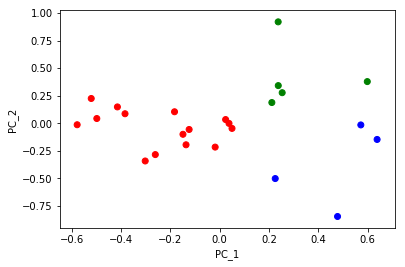

In [316]:
import matplotlib.pyplot as plt
from matplotlib import pylab
from scipy import stats
%matplotlib inline 
color= ['red' if l == 0 else 'blue' if l == 1 else 'green' for l in labels]
plt.scatter(dataset[:,0],dataset[:,1], color = color)
plt.xlabel('PC_1')
plt.ylabel('PC_2')
plt.show()

In [328]:
from scipy.cluster.hierarchy import dendrogram, linkage

Z = linkage(X, 'ward')


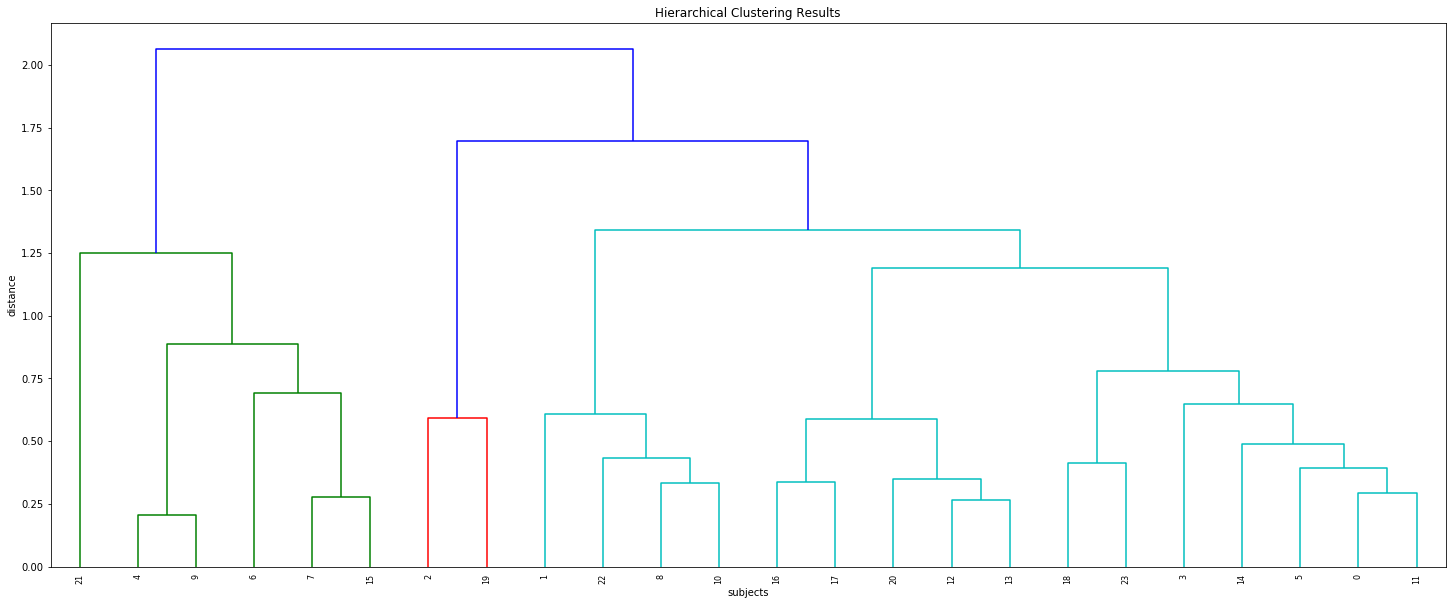

In [330]:
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Results')
plt.xlabel('subjects')
plt.ylabel('distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
)
plt.show()

In [356]:
from scipy.cluster.hierarchy import fcluster
labels_h = fcluster(Z, 3, criterion = 'maxclust')

In [362]:
metrics.v_measure_score(true_label_activeness, labels_h) 
metrics.v_measure_score(true_label, labels_h) 


0.14420101224693324